# Calculation and Analysis Notebook

This notebook performs statistical analysis and calculations on completed SLiM simulation results. It rebuilds the Experiment object from saved tree sequences, computes allele frequency spectra (AFS), runs BIM estimation, and calculates various statistics (e.g., bsfs, Tajima's D, tree statistics, Colless index) for downstream analysis.

**What it does:**
- Rebuilds Experiment objects from saved tree sequence files
- Calculates site frequency spectra (SFS) and allele frequency spectra (AFS)
- Runs BIM (Software for β-Imbalance) estimation on tree sequences. BIM is a method for robust detection of natural selection using a probabilistic model of tree imbalance, from the paper "Robust detection of natural selection using a probabilistic model of tree imbalance" ([GitHub repository](https://github.com/jthlab/bim))
- Computes summary statistics for neutral and selective models
- Prepares data for ROC analysis and statistical comparisons

**Important:**
- **This notebook must be run with the `sweep312` conda environment** (requires tskit = 0.5.8)
- **This notebook must be run after completing the simulations** (or using cached results) **and running necessary R scripts to complete F matrix related calculations**

## Set Dependencies and Params

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ruptures as rpt
import seaborn as sns
from matplotlib import rc
rc('text', usetex=True)
from scipy.stats import norm
from PSlim2 import Experiment, get_eps, ROC, ROCAUC

In [2]:
Train = True # False if you do analysis with given simulations and estimates
pyslurm = None  # instead of '/home/enes/pyslurm/'
srun = None
srun_est = None

In [3]:
N = 50
Ne = 10000
L = 100000
r = 1.25e-8
mu = 2.5e-8

extmut = 0 # no extra mutation (just one)
Until = 100000 # make sure model runs until it reaches the desired frequency Until>>Ne
h = 0.5

Args = {}

Args['Fn'] = {'Simulator':'slim', 'slimTxt':'Slim.txt', 
              'N':N, 'Ne':Ne, 'L':L, 'r':r, 'mu':mu, 
              's':0, 'h':0.5, 'extmut':0, 'reset_lost': 0,
              'Until':Ne, 'Freq':0.25, 'rep':0, 
              'srun':srun, 'srun_est':srun_est,
              'etapath':'../Simulation/Slim(primary)/etas/Fn.json', 'start': Until + 100,
              'name':'Neutral Model'}

for s in [0.02, 0.01, 0.003, 0.001]:
    for Freq in [0.25, 0.5, 0.75]:
# for s in [0.01]:
#     for Freq in [0.75]:
        name = 's='+str(s)+'F='+str(Freq)
        arg = Args['Fn'].copy()
        arg['s'] = s
        arg['Freq'] = Freq
        arg['Until'] = 300000
        arg['name'] = name
        arg['reset_lost'] = 1
        Args[name] = arg

cID = 3 # simulation class id for directional selection constant pop size simulations
nrep = 250 # For initial testing

## Rebuild X from Saved Trees

In [4]:
# Rebuild `X` from on-disk trees (no simulations)
import os, re, json
import numpy as np
import tskit

from PSlim2 import Experiment  # import from your PSlim.py

# --- your existing Args and cID ---
X = Experiment(cID=cID, nrep=nrep, Args=Args)   # nrep is a placeholder; we'll overwrite simIDs

# TREES_DIR = "trees"  # <- exactly the folder you asked for (relative path: ./trees)
# Replace with the correct path to trees folder
TREES_DIR = "../Simulation/Slim(primary)/trees/"

def _matching_paths(regex, folder=TREES_DIR):
    """Return paths like trees/r########.trees that match the regex."""
    r = re.compile(regex)
    files = os.listdir(folder) if os.path.isdir(folder) else []
    return [os.path.join(folder, f) for f in files if r.match(f)]

def _extract_sim_ids(paths):
    """From paths like trees/r3020001.trees or trees/ir3020001.trees, return integer IDs."""
    out = []
    for p in paths:
        m = re.search(r'(\d+)\.trees$', p)
        if m:
            out.append(int(m.group(1)))
    return sorted(set(out))

# Fill in X.simIDs by discovering what’s already on disk (pattern: r{cID}{set_index:02d}{rep:04d}.trees)
for i, setid in enumerate(X.setids):
    regex = f"r{cID}{i:02d}[0-9]{{4}}\\.trees"   # e.g. r300000.trees pattern (escaped dot)
    rpaths = _matching_paths(regex, folder=TREES_DIR)  # returns trees/<filename>
    found_ids = _extract_sim_ids(rpaths)               # just the numeric IDs
    X.simIDs[setid] = found_ids
    if not found_ids:
        print(f"[warn] no r*.trees found for setid={setid} (pattern: {regex})")

# Recompute SFS from the trees we found (fast)
X.calc_sfs()
X.train_eta()

print("Rebuilt X:")
for sid in X.setids:
    print(f"  {sid}: {len(X.simIDs[sid])} replicates; AFS length={len(X.AFS[sid])}")


Done!
Rebuilt X:
  Fn: 500 replicates; AFS length=49
  s=0.02F=0.25: 250 replicates; AFS length=49
  s=0.02F=0.5: 250 replicates; AFS length=49
  s=0.02F=0.75: 250 replicates; AFS length=49
  s=0.01F=0.25: 250 replicates; AFS length=49
  s=0.01F=0.5: 250 replicates; AFS length=49
  s=0.01F=0.75: 250 replicates; AFS length=49
  s=0.003F=0.25: 250 replicates; AFS length=49
  s=0.003F=0.5: 250 replicates; AFS length=49
  s=0.003F=0.75: 250 replicates; AFS length=49
  s=0.001F=0.25: 100 replicates; AFS length=49
  s=0.001F=0.5: 100 replicates; AFS length=49
  s=0.001F=0.75: 100 replicates; AFS length=49


## Calculate Statistics

In [6]:
# # Use a constant demography placeholder
# import os, json
# os.makedirs("etas", exist_ok=True)

# # constant size demography as a placeholder
# with open("etas/constant.json", "w") as f:
#     json.dump({0: {"t": [0], "a": [1.0]}}, f)

# # make every set point to it
# for setid in X.setids:
#     Args[setid]["etapath"] = "etas/constant.json"

# treew = "split"
BIM = "/opt/anaconda3/envs/sweep312/bin/bim"   # your `which bim` result
onlysimloc = True

for setid in X.setids:
    # X.est(BIM, setid, now=10, arg="--wsz 5000 --ssz 2500 --r2t=0.005 --r2s=0.001 --weights=split")
    if onlysimloc:
        X.est(BIM, setid, now=10, arg="--wsz 1000 --ssz 500 --r2t=0.05 --r2s=0.1 --weights=split", onlysimloc=onlysimloc)
    else:
        X.est(BIM, setid, now=10, arg="--r2t=0.005 --r2s=0.001 --weights=split", onlysimloc=onlysimloc)

for setid in X.setids:
    X.merge_outs_nonstrict(setid, onlysimloc=onlysimloc)

myorder = [0, 1, 2, 3, 4]

X.setids


If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!


['Fn',
 's=0.02F=0.25',
 's=0.02F=0.5',
 's=0.02F=0.75',
 's=0.01F=0.25',
 's=0.01F=0.5',
 's=0.01F=0.75',
 's=0.003F=0.25',
 's=0.003F=0.5',
 's=0.003F=0.75',
 's=0.001F=0.25',
 's=0.001F=0.5',
 's=0.001F=0.75']

In [8]:
# Process outs_onlysimloc files: average statistics over positions 45000-55000 for each path
import os
import glob

if onlysimloc:
    # Define the position range to average over
    pos_start = 45000
    pos_end = 55000
    
    # Process each CSV file in outs_onlysimloc folder
    outs_dir = 'outs_onlysimloc'
    csv_files = glob.glob(os.path.join(outs_dir, '*.csv'))
    
    for csv_file in csv_files:
        print(f"Processing {os.path.basename(csv_file)}...")
        
        # Read the CSV file
        df = pd.read_csv(csv_file, comment='#')
        
        # Filter rows where the interval [start, end] overlaps with [pos_start, pos_end]
        # An interval overlaps if: start < pos_end AND end > pos_start
        mask = (df['start'] < pos_end) & (df['end'] > pos_start)
        df_filtered = df[mask].copy()
        
        if len(df_filtered) == 0:
            print(f"  Warning: No rows found in range {pos_start}-{pos_end} for {os.path.basename(csv_file)}")
            continue
        
        # Identify numeric columns (exclude 'path', 'start', 'end')
        numeric_cols = df_filtered.select_dtypes(include=[np.number]).columns.tolist()
        # Explicitly remove 'path', 'start', and 'end' from numeric columns
        # (path contains integers but should not be averaged)
        for col in ['path', 'start', 'end']:
            if col in numeric_cols:
                numeric_cols.remove(col)
        
        # Group by path and average numeric columns
        df_avg = df_filtered.groupby('path')[numeric_cols].mean().reset_index()
        
        # Set start and end to the range we averaged over
        df_avg['start'] = pos_start
        df_avg['end'] = pos_end
        
        # Reorder columns to match original format (start, end, then other columns, path last)
        col_order = ['start', 'end'] + [c for c in df.columns if c not in ['start', 'end', 'path']] + ['path']
        # Only include columns that exist in df_avg
        col_order = [c for c in col_order if c in df_avg.columns]
        df_avg = df_avg[col_order]
        
        # Overwrite the original file
        df_avg.to_csv(csv_file, index=False)
        print(f"  Averaged {len(df_filtered)} rows into {len(df_avg)} rows (one per path)")
    
    print("Done processing all files in outs_onlysimloc/")
else:
    print("Skipping: onlysimloc is False, files are already in the correct format")


Processing 3s=0.02F=0.25.csv...
  Averaged 5250 rows into 250 rows (one per path)
Processing 3s=0.001F=0.5.csv...
  Averaged 2100 rows into 100 rows (one per path)
Processing 3s=0.003F=0.25.csv...
  Averaged 5250 rows into 250 rows (one per path)
Processing 3s=0.001F=0.75.csv...
  Averaged 2100 rows into 100 rows (one per path)
Processing 3s=0.02F=0.5.csv...
  Averaged 5250 rows into 250 rows (one per path)
Processing 3Fn.csv...
  Averaged 10500 rows into 500 rows (one per path)
Processing 3s=0.01F=0.75.csv...
  Averaged 5250 rows into 250 rows (one per path)
Processing 3s=0.001F=0.25.csv...
  Averaged 2100 rows into 100 rows (one per path)
Processing 3s=0.003F=0.5.csv...
  Averaged 5250 rows into 250 rows (one per path)
Processing 3s=0.02F=0.75.csv...
  Averaged 5250 rows into 250 rows (one per path)
Processing 3s=0.003F=0.75.csv...
  Averaged 5250 rows into 250 rows (one per path)
Processing 3s=0.01F=0.25.csv...
  Averaged 5250 rows into 250 rows (one per path)
Processing 3s=0.01F=0.

## Show summary stats

In [6]:
# choose the stats that exist in your CSVs
stats = ['bsfs', 'TajD', 'btree', 'Colless']

df = pd.read_csv(X.df['Fn']).dropna()
n = df.shape[0]
print(f"n rows = {n}")

for stat in stats:
    s = df[stat]
    p = np.mean(np.abs((s - s.mean()) / s.std()) > 1.96)
    se = np.sqrt(p * (1 - p) / n)
    print(f"{stat:8s}  SE≈ {se:.4f}")

n rows = 500
bsfs      SE≈ 0.0092
TajD      SE≈ 0.0101
btree     SE≈ 0.0105
Colless   SE≈ 0.0090


## ROC Curve for Selective Region

   start    end     N        SS      FulD      bsfs      FayH      FerL  \
0  45000  55000  50.0  3.714286 -0.142588 -0.028545 -0.019793 -0.359945   
1  45000  55000  50.0  4.666667 -1.755012 -0.023941  0.034006  0.294335   
2  45000  55000  50.0  4.238095  0.199220  0.008381 -0.041424 -0.301900   
3  45000  55000  50.0  3.904762  0.217416 -0.033833 -0.042400 -0.384817   
4  45000  55000  50.0  4.428571 -1.017820  0.009469  0.147374  0.567188   

       ZngE      TajD     btree     Omega   Colless     path  
0  0.206699 -0.250445 -1.067581 -0.320625 -0.216960  3010000  
1 -0.394443 -0.401316 -0.447893 -0.784133 -0.161457  3010001  
2  0.351580  0.262365 -0.471996 -1.208765 -0.158434  3010002  
3  0.228814 -0.238303 -1.033077 -0.704065 -0.212437  3010003  
4 -0.524229 -0.144603  0.785664  0.836028 -0.098639  3010004  
⚠️  Missing D1F file: roc_onlysimloc/D1F_scores_s=0.02F=0.25.csv
⚠️  Missing D1F file: roc_onlysimloc/D1FW_scores_s=0.02F=0.25.csv
⚠️  Missing D1F file: roc_onlysimloc/D0F

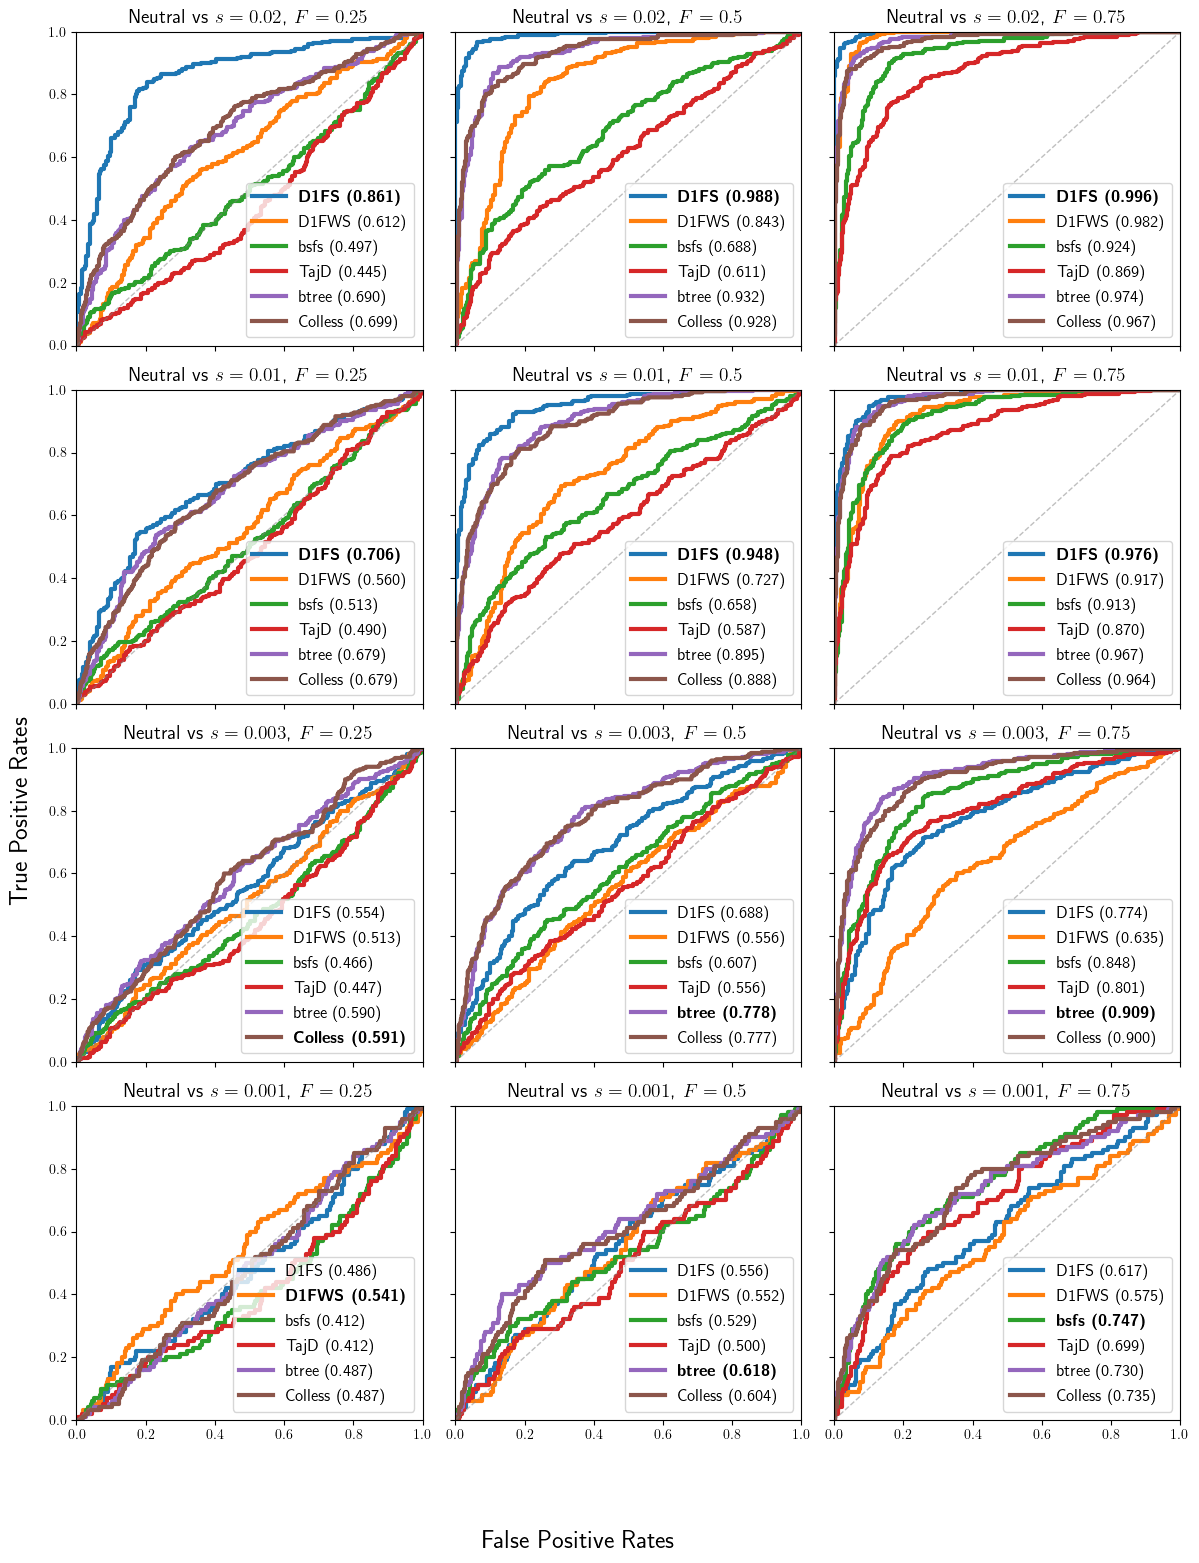

In [11]:
# If you had ROCAUC() earlier (from your PSlim helpers), reuse it.
# Otherwise, uncomment this local version:
from sklearn.metrics import roc_curve, roc_auc_score
def ROCAUC(y0, y1, score_ascending=False):
    if not score_ascending:
        # negate both so that "larger" means more positive class
        y0 = -np.asarray(y0)
        y1 = -np.asarray(y1)
    y_true = np.r_[np.zeros(len(y0)), np.ones(len(y1))]
    y_score = np.r_[y0, y1]
    fpr, tpr, _ = roc_curve(y_true, y_score)
    return fpr, tpr, roc_auc_score(y_true, y_score)

# Stats we’ll compare (present in your files)
stats = ['D1F', 'D1FW', 'D0F', 'D0FW', 'D1FS', 'D1FWS', 'bsfs', 'TajD', 'btree', 'Colless']
# Order for legend (all 10 stats: D1F, D1FW, D0F, D0FW, D1FS, D1FWS, bsfs, TajD, btree, Colless)
myorder = list(range(len(stats)))  # [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Determine which folders to use based on onlysimloc
if onlysimloc:
    outs_dir = 'outs_onlysimloc'
    roc_dir = 'roc_onlysimloc'
else:
    outs_dir = 'outs'
    roc_dir = 'roc'

# Load neutral set once
neutral_key = 'Fn'
# Construct path manually to use the correct directory
neutral_path = os.path.join(outs_dir, os.path.basename(X.df[neutral_key]))
df_neu = pd.read_csv(neutral_path).dropna()

# Flip signs to match original intent (they flipped iColless and FulD)
def align_signs(df):
    df = df.copy()
    if 'Colless' in df.columns:
        df['Colless'] = -df['Colless']
    if 'FulD' in df.columns:
        df['FulD'] = -df['FulD']
    return df

df_neu = align_signs(df_neu)

fprs, tprs, aucs, blds = {}, {}, {}, {}

# build pairings: neutral vs each selection combo
names = []
pairs = []
for s in [0.02, 0.01, 0.003, 0.001]:
    for F in [0.25, 0.5, 0.75]:
        k2 = f"s={s}F={F}"
        # Check if file exists in the correct directory
        if k2 in X.df:
            selective_path = os.path.join(outs_dir, os.path.basename(X.df[k2]))
            if os.path.exists(selective_path):
                pairs.append((neutral_key, k2))
                names.append(f"Neutral vs $s={s}$, $F={F}$")

for name, (k1, k2) in zip(names, pairs):
    df1 = df_neu
    # Construct path manually to use the correct directory
    selective_path = os.path.join(outs_dir, os.path.basename(X.df[k2]))
    df2 = pd.read_csv(selective_path).dropna()
    df2 = align_signs(df2)
    print(df2.head())

    max_auc = -1
    best_key = None

    for key in stats:
        if key in ['D1F', 'D1FW', 'D0F', 'D0FW', 'D1FS', 'D1FWS']:
            # Load distances exported from R for this scenario
            if key == 'D1F':
                csv_path = os.path.join(roc_dir, f"D1F_scores_{k2}.csv")
            elif key == 'D1FW':
                csv_path = os.path.join(roc_dir, f"D1FW_scores_{k2}.csv")
            elif key == 'D0F':
                csv_path = os.path.join(roc_dir, f"D0F_scores_{k2}.csv")
            elif key == 'D0FW':
                csv_path = os.path.join(roc_dir, f"D0FW_scores_{k2}.csv")
            elif key == 'D1FS':
                csv_path = os.path.join(roc_dir, f"D1FS_scores_{k2}.csv")
            elif key == 'D1FWS':
                csv_path = os.path.join(roc_dir, f"D1FWS_scores_{k2}.csv")
            if not os.path.exists(csv_path):
                print("⚠️  Missing D1F file:", csv_path)
                continue
            if os.path.exists(csv_path):
                sc = pd.read_csv(csv_path)
                y_true = sc['label'].to_numpy()
                y_score = sc['score'].to_numpy()
                # sklearn expects larger score => positive class (1), which matches your R setup
                fpr, tpr, _ = roc_curve(y_true, y_score)
                auc = roc_auc_score(y_true, y_score)
                fprs[(key, name)] = fpr
                tprs[(key, name)] = tpr
                aucs[(key, name)] = auc
                if auc > max_auc:
                    max_auc = auc
                    best_key = key
            continue

        if key not in df1.columns or key not in df2.columns:
            continue
        fpr, tpr, auc = ROCAUC(df1[key], df2[key], score_ascending=False)
        fprs[(key, name)] = fpr
        tprs[(key, name)] = tpr
        aucs[(key, name)] = auc
        if auc > max_auc:
            max_auc = auc
            best_key = key
    blds[name] = best_key

# Plot (4×3 like original if you have 12 panels; adapt rows/cols to len(names))
ncols = 3
nrows = int(np.ceil(len(names)/ncols))
fig, ax = plt.subplots(nrows, ncols, figsize=(13, 5 + 3*nrows), sharex=True, sharey=True)
if nrows == 1:
    ax = np.array([ax])  # make 2D for consistent indexing

for i, name in enumerate(names):
    c, r = i % ncols, i // ncols
    for key in stats:
        if (key, name) not in fprs:
            continue
        fpr = fprs[(key, name)]
        tpr = tprs[(key, name)]
        auc = aucs[(key, name)]

        label_map = {'D1F':'D1F', 'D1FW': 'D1FW', 'D0F':'D0F', 'D0FW': 'D0FW', 
                     'D1FS':'D1FS', 'D1FWS': 'D1FWS', 'btree':'btree', 'Colless':'Colless', 
                     'Omega':'Omega', 'bsfs':'bsfs', 'TajD':'TajD', 'FulD':'FulD'}
        label = f"{label_map.get(key, key)} ({auc:.3f})"

        if blds[name] == key:
            label = r"\textbf{"+label+"}"

        ax[r, c].plot(fpr, tpr, label=label, linewidth=3)

    ax[r, c].set_title(name, size=14)
    # Order legend entries based on stats list order
    handles, labels = ax[r, c].get_legend_handles_labels()
    if handles:
        # Create a mapping from stat name to index in stats list
        stat_to_idx = {stat: idx for idx, stat in enumerate(stats)}
        # Sort handles and labels by their position in the stats list
        # Extract stat name from label (format: "StatName (AUC)" or "\textbf{StatName (AUC)}")
        def get_stat_from_label(label):
            # Remove LaTeX formatting if present
            import re
            label_clean = re.sub(r'\\textbf\{', '', label)
            label_clean = re.sub(r'\}', '', label_clean)
            # Extract stat name (everything before the first space or parenthesis)
            stat_name = label_clean.split(' ')[0].split('(')[0]
            return stat_name
        
        # Create list of (handle, label, stat_index) tuples
        handle_label_pairs = [(h, l, stat_to_idx.get(get_stat_from_label(l), len(stats))) 
                              for h, l in zip(handles, labels)]
        # Sort by stat_index
        handle_label_pairs.sort(key=lambda x: x[2])
        # Reorder handles and labels
        ordered_handles = [h for h, _, _ in handle_label_pairs]
        ordered_labels = [l for _, l, _ in handle_label_pairs]
        ax[r, c].legend(ordered_handles, ordered_labels,
                        loc='lower right', prop={'size': 12})

for a in ax.ravel():
    a.set_xlim(0, 1); a.set_ylim(0, 1)
    a.plot([0,1], [0,1], ls='--', lw=1, color='gray', alpha=0.5)

fig.text(0.5, 0.07, 'False Positive Rates', ha='center', va='center', size=18)
fig.text(0.07, 0.5, 'True Positive Rates', rotation=90, ha='center', va='center', size=18)
plt.tight_layout(rect=[0.08, 0.12, 0.98, 0.98])
# plt.savefig('plots/Constant_Directional_no_infer.pdf', dpi=600, bbox_inches='tight')
plt.show()


## Plot ROC Curve

   start       end   N   SS      FayH      TajD      FulD      FerL      bsfs  \
0      0  100001.0  50  436  0.001208 -0.186475 -0.478891  0.120105 -0.088122   
1      0  100001.0  50  477 -0.066477 -0.192273 -0.962693 -0.448581 -0.680331   
2      0  100001.0  50  402 -0.044937  0.086427  0.602202 -0.429815 -0.032020   
3      0  100001.0  50  387  0.016302 -0.045516 -0.573202  0.164172  0.161209   
4      0  100001.0  50  363  0.044775 -0.192508 -0.420643  0.490157  0.211568   

       ZngE     btree   Colless     Omega     path  
0 -0.201642 -0.556261 -0.156315 -0.064627  3010000  
1  0.293896 -0.506530 -0.149273 -0.478708  3010001  
2  0.421358 -0.011977 -0.129790 -0.166909  3010002  
3 -0.167374 -0.782799 -0.167461 -0.033980  3010003  
4 -0.528790  0.461077 -0.119295  0.273670  3010004  
   start       end   N   SS      FayH      bsfs      ZngE      FulD      TajD  \
0      0  100001.0  50  406 -0.020637  0.035988  0.241600 -0.246627  0.086234   
1      0  100001.0  50  442 -0.22

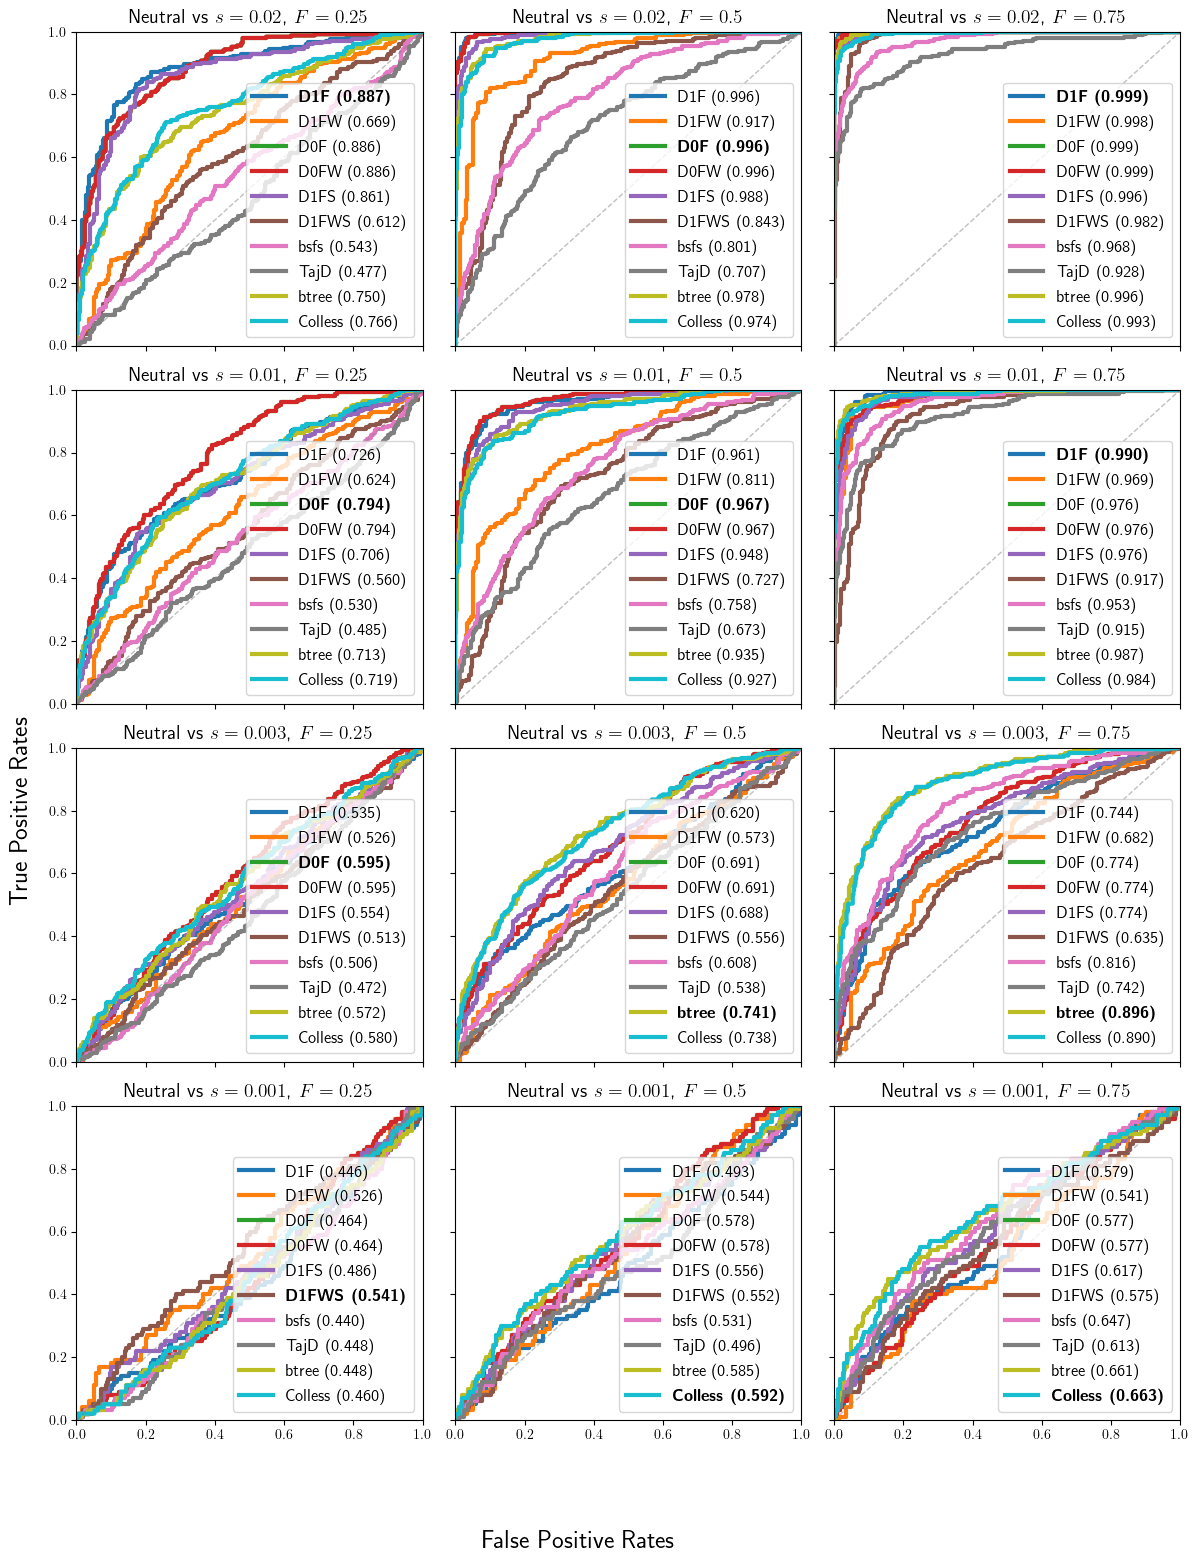

In [9]:
# If you had ROCAUC() earlier (from your PSlim helpers), reuse it.
# Otherwise, uncomment this local version:
from sklearn.metrics import roc_curve, roc_auc_score
def ROCAUC(y0, y1, score_ascending=False):
    if not score_ascending:
        # negate both so that "larger" means more positive class
        y0 = -np.asarray(y0)
        y1 = -np.asarray(y1)
    y_true = np.r_[np.zeros(len(y0)), np.ones(len(y1))]
    y_score = np.r_[y0, y1]
    fpr, tpr, _ = roc_curve(y_true, y_score)
    return fpr, tpr, roc_auc_score(y_true, y_score)

# Stats we’ll compare (present in your files)
stats = ['D1F', 'D1FW', 'D0F', 'D0FW', 'D1FS', 'D1FWS', 'bsfs', 'TajD', 'btree', 'Colless']
# Order for legend (all 10 stats: D1F, D1FW, D0F, D0FW, D1FS, D1FWS, bsfs, TajD, btree, Colless)
myorder = list(range(len(stats)))  # [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Load neutral set once
neutral_key = 'Fn'
df_neu = pd.read_csv(X.df[neutral_key]).dropna()

# Flip signs to match original intent (they flipped iColless and FulD)
def align_signs(df):
    df = df.copy()
    if 'Colless' in df.columns:
        df['Colless'] = -df['Colless']
    if 'FulD' in df.columns:
        df['FulD'] = -df['FulD']
    return df

df_neu = align_signs(df_neu)

fprs, tprs, aucs, blds = {}, {}, {}, {}

# build pairings: neutral vs each selection combo
names = []
pairs = []
for s in [0.02, 0.01, 0.003, 0.001]:
    for F in [0.25, 0.5, 0.75]:
        k2 = f"s={s}F={F}"
        if k2 in X.df and os.path.exists(X.df[k2]):
            pairs.append((neutral_key, k2))
            names.append(f"Neutral vs $s={s}$, $F={F}$")

for name, (k1, k2) in zip(names, pairs):
    df1 = df_neu
    df2 = pd.read_csv(X.df[k2]).dropna()
    df2 = align_signs(df2)
    print(df2.head())

    max_auc = -1
    best_key = None

    for key in stats:
        if key in ['D1F', 'D1FW', 'D0F', 'D0FW', 'D1FS', 'D1FWS']:
            # Load distances exported from R for this scenario
            if key == 'D1F':
                csv_path = os.path.join("roc", f"D1F_scores_{k2}.csv")
            elif key == 'D1FW':
                csv_path = os.path.join("roc", f"D1FW_scores_{k2}.csv")
            elif key == 'D0F':
                csv_path = os.path.join("roc", f"D0F_scores_{k2}.csv")
            elif key == 'D0FW':
                csv_path = os.path.join("roc", f"D0FW_scores_{k2}.csv")
            elif key == 'D1FS':
                csv_path = os.path.join("roc", f"D1FS_scores_{k2}.csv")
            elif key == 'D1FWS':
                csv_path = os.path.join("roc", f"D1FWS_scores_{k2}.csv")
            if not os.path.exists(csv_path):
                print("⚠️  Missing D1F file:", csv_path)
                continue
            if os.path.exists(csv_path):
                sc = pd.read_csv(csv_path)
                y_true = sc['label'].to_numpy()
                y_score = sc['score'].to_numpy()
                # sklearn expects larger score => positive class (1), which matches your R setup
                fpr, tpr, _ = roc_curve(y_true, y_score)
                auc = roc_auc_score(y_true, y_score)
                fprs[(key, name)] = fpr
                tprs[(key, name)] = tpr
                aucs[(key, name)] = auc
                if auc > max_auc:
                    max_auc = auc
                    best_key = key
            continue

        if key not in df1.columns or key not in df2.columns:
            continue
        fpr, tpr, auc = ROCAUC(df1[key], df2[key], score_ascending=False)
        fprs[(key, name)] = fpr
        tprs[(key, name)] = tpr
        aucs[(key, name)] = auc
        if auc > max_auc:
            max_auc = auc
            best_key = key
    blds[name] = best_key

# Plot (4×3 like original if you have 12 panels; adapt rows/cols to len(names))
ncols = 3
nrows = int(np.ceil(len(names)/ncols))
fig, ax = plt.subplots(nrows, ncols, figsize=(13, 5 + 3*nrows), sharex=True, sharey=True)
if nrows == 1:
    ax = np.array([ax])  # make 2D for consistent indexing

for i, name in enumerate(names):
    c, r = i % ncols, i // ncols
    for key in stats:
        if (key, name) not in fprs:
            continue
        fpr = fprs[(key, name)]
        tpr = tprs[(key, name)]
        auc = aucs[(key, name)]

        label_map = {'D1F':'D1F', 'D1FW': 'D1FW', 'D0F':'D0F', 'D0FW': 'D0FW', 
                     'D1FS':'D1FS', 'D1FWS': 'D1FWS', 'btree':'btree', 'Colless':'Colless', 
                     'Omega':'Omega', 'bsfs':'bsfs', 'TajD':'TajD', 'FulD':'FulD'}
        label = f"{label_map.get(key, key)} ({auc:.3f})"

        if blds[name] == key:
            label = r"\textbf{"+label+"}"

        ax[r, c].plot(fpr, tpr, label=label, linewidth=3)

    ax[r, c].set_title(name, size=14)
    # Order legend entries based on stats list order
    handles, labels = ax[r, c].get_legend_handles_labels()
    if handles:
        # Create a mapping from stat name to index in stats list
        stat_to_idx = {stat: idx for idx, stat in enumerate(stats)}
        # Sort handles and labels by their position in the stats list
        # Extract stat name from label (format: "StatName (AUC)" or "\textbf{StatName (AUC)}")
        def get_stat_from_label(label):
            # Remove LaTeX formatting if present
            import re
            label_clean = re.sub(r'\\textbf\{', '', label)
            label_clean = re.sub(r'\}', '', label_clean)
            # Extract stat name (everything before the first space or parenthesis)
            stat_name = label_clean.split(' ')[0].split('(')[0]
            return stat_name
        
        # Create list of (handle, label, stat_index) tuples
        handle_label_pairs = [(h, l, stat_to_idx.get(get_stat_from_label(l), len(stats))) 
                              for h, l in zip(handles, labels)]
        # Sort by stat_index
        handle_label_pairs.sort(key=lambda x: x[2])
        # Reorder handles and labels
        ordered_handles = [h for h, _, _ in handle_label_pairs]
        ordered_labels = [l for _, l, _ in handle_label_pairs]
        ax[r, c].legend(ordered_handles, ordered_labels,
                        loc='lower right', prop={'size': 12})

for a in ax.ravel():
    a.set_xlim(0, 1); a.set_ylim(0, 1)
    a.plot([0,1], [0,1], ls='--', lw=1, color='gray', alpha=0.5)

fig.text(0.5, 0.07, 'False Positive Rates', ha='center', va='center', size=18)
fig.text(0.07, 0.5, 'True Positive Rates', rotation=90, ha='center', va='center', size=18)
plt.tight_layout(rect=[0.08, 0.12, 0.98, 0.98])
# plt.savefig('plots/Constant_Directional_no_infer.pdf', dpi=600, bbox_inches='tight')
plt.show()


## Emperical SFSs

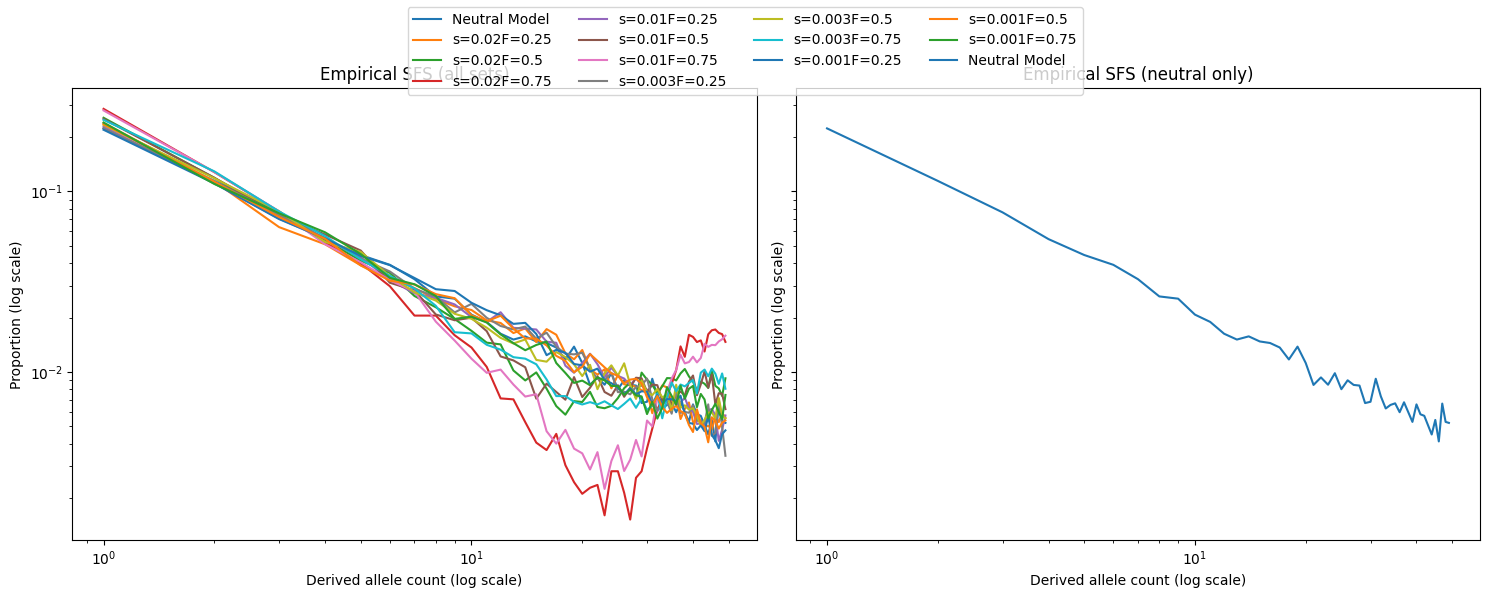

In [27]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1, 2, figsize=(15, 6), sharex=True, sharey=True)

# left: all sets’ SFS
for setid in X.setids:
    name = Args[setid]['name']
    sfs = X.AFS[setid] / X.AFS[setid].sum()
    ax[0].plot(range(1, len(sfs)+1), sfs, label=name)

# right: just neutrals (empirical only; no ebl)
for setid in X.neutrals:
    sfs = X.AFS[setid] / X.AFS[setid].sum()
    ax[1].plot(range(1, len(sfs)+1), sfs, label=Args[setid]['name'])

for a in ax:
    a.set_xscale('log')
    a.set_yscale('log')
    a.set_xlabel('Derived allele count (log scale)')
    a.set_ylabel('Proportion (log scale)')

ax[0].set_title('Empirical SFS (all sets)')
ax[1].set_title('Empirical SFS (neutral only)')
fig.legend(ncol=4, loc='upper center')
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()


## P-value vs Location

In [30]:
# --- Imports (match theirs + utilities) ---
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import norm
import ruptures as rpt

# ──────────────────────────────────────────────────────────────────────────────
# Choose scenarios and stats
# ──────────────────────────────────────────────────────────────────────────────
neutral_key   = 'Fn'            # your neutral label in X.df
selected_key  = 's=0.01F=0.75'  # pick any key in X.df for the selected scenario

# Stats available from your BIM run.
# If you didn't compute inferred-tree stats, omit 'ibtree','iColless','iOmega'.
stats = ['bsfs', 'TajD']  # you can add 'FayH','ZngE','FerL','FulD','Omega','btree','Colless' if present

# -------- choose the tail for each statistic --------
# meaning: alt = '<' → smaller-than-neutral is evidence for selection
#          alt = '>' → larger-than-neutral is evidence for selection
STAT_ALT = {
    'bsfs':   '<',
    'TajD':   '<',
    'FayH':   '>',
    'ZngE':   '>',
    'FerL':   '>',
    'FulD':   '>',   # many papers treat large +FulD as sweep-like; adjust if needed
    'Omega':  '>',
    'btree':  '>',   # tree-imbalance tends to increase near sweeps
    'Colless':'>',
    'iColless':'>',
    'iOmega': '>'
}

# If you prefer to flip a stat instead of changing its tail, list it here:
SIGN_FLIP = set([
    # 'FulD', 'iColless'     # uncomment if you want to invert these before scanning
])

# Load the merged outputs (created via X.merge_outs(...))
df0 = pd.read_csv(X.df[neutral_key]).dropna()   # neutral
df1 = pd.read_csv(X.df[selected_key]).dropna()  # selected

# Keep only windows with finite values for the chosen stats
keep_cols = ['start','end','path'] + stats
df0 = df0[keep_cols].replace([np.inf,-np.inf], np.nan).dropna()
df1 = df1[keep_cols].replace([np.inf,-np.inf], np.nan).dropna()

# # Genomic midpoints & selection band (your SLiM beneficial site is at L/2)
# L   = X.Args[selected_key]['L']
# mut = L // 2
# st  = mut - 250_000
# en  = mut + 250_000

# cmap = cm.get_cmap('tab20').colors
# sel_col, neu_col = cmap[0], cmap[1]

# for k in list(dscans.keys()):
#     ds = dscans[k].copy()

#     sel_flag = (st <= ds['end']) & (ds['start'] <= en)
#     ds['Selection'] = sel_flag.astype(bool)

#     # FIX: build RGB per row without NumPy broadcasting
#     ds['color'] = [sel_col if s else neu_col for s in ds['Selection'].to_numpy()]
#     # alpha can still use np.where since it's scalar
#     ds['alpha'] = np.where(ds['Selection'].to_numpy(), 1.0, 0.2)

#     dscans[k] = ds
#     print(k, "selected segments:", int(sel_flag.sum()), "of", len(ds))

# ──────────────────────────────────────────────────────────────────────────────
# Robust neutral autocovariance & p-value machinery
# ──────────────────────────────────────────────────────────────────────────────

def _autocovariance_1path(x, max_lag):
    """
    Mean-centered autocovariance for lags 0..max_lag (biased by n).
    Robust to short series. Returns length max_lag+1 array (may be shorter if needed).
    """
    x = np.asarray(x, dtype=float)
    x = x[np.isfinite(x)]
    n = len(x)
    if n < 3 or max_lag < 0:
        return np.full(max_lag + 1, np.nan, dtype=float)
    max_lag = min(max_lag, n - 2)  # need at least 2 points per slice
    xc = x - x.mean()
    acov = np.empty(max_lag + 1, dtype=float)
    for k in range(max_lag + 1):
        acov[k] = np.dot(xc[:n - k], xc[k:]) / n  # biased estimator
    return acov

def estimate_neutral_cov(df_neutral, key, min_windows=10):
    """
    Average per-path autocovariance over a common lag range across all
    *kept* neutral paths (paths with >= min_windows windows).
    Returns (mu_g, cov_vector).
    """
    # filter out very short paths
    counts = df_neutral.groupby('path').size()
    keep_paths = counts[counts >= min_windows].index
    dff = df_neutral[df_neutral['path'].isin(keep_paths)].copy()

    if dff.empty:
        return float(df_neutral[key].mean()), np.array([1e-12], dtype=float)

    win_counts = dff.groupby('path').size().to_numpy()
    common_max_lag = int(max(1, np.min(win_counts) - 2))

    cov_list = []
    for _, sub in dff.groupby('path'):
        x = sub[key].to_numpy()
        ac = _autocovariance_1path(x, common_max_lag)
        if ac.size > 0 and np.isfinite(ac[0]):
            cov_list.append(ac)

    if len(cov_list) == 0:
        return float(dff[key].mean()), np.array([1e-12], dtype=float)

    cov = np.nanmean(np.vstack(cov_list), axis=0)
    if not np.isfinite(cov[0]) or cov[0] <= 0:
        cov[0] = max(1e-12, np.nanmean([ac[0] for ac in cov_list]))
    mu_g = float(dff[key].mean())
    return mu_g, cov

def _cov_at_lag(cov, k):
    return cov[k] if (0 <= k < len(cov)) else 0.0

# -------- one-sided Z-scan p-value --------
def Zscan_one_sided(x, mu_g, cov, weights='gaussian', alt='<'):
    """
    Weighted-mean Z test vs neutral mean, with neutral lag-covariance.
    Returns a ONE-SIDED p-value according to alt ('<' or '>').
    """
    x = np.asarray(x, float)
    x = x[np.isfinite(x)]
    nX = len(x)
    if nX < 3:
        return np.nan

    if weights == 'linear':
        w = np.arange(1, nX + 1, dtype=float)
        w = np.minimum(w, w[::-1])
    elif weights == 'uniform':
        w = np.ones(nX, dtype=float)
    else:
        w = np.arange(1, nX + 1, dtype=float)
        m = (nX + 1) / 2.0
        w = norm.pdf(5 * (w - m) / (nX + 1))

    w /= w.sum()
    x_bar = float(np.dot(x, w))

    var = (w**2).sum() * _cov_at_lag(cov, 0)
    for k in range(1, min(len(cov), nX)):
        var += 2.0 * _cov_at_lag(cov, k) * np.dot(w[:-k], w[k:])
    if not np.isfinite(var) or var <= 0:
        return np.nan

    z = (x_bar - mu_g) / np.sqrt(var)

    if alt == '<':
        # left-tail: small values → small p
        return float(norm.cdf(z))
    elif alt == '>':
        # right-tail: large values → small p
        return float(1.0 - norm.cdf(z))
    else:
        # fallback: two-sided
        return 2.0 * min(norm.cdf(z), 1.0 - norm.cdf(z))

def Zscan_weighted_mean(x, mu_g, cov, weights='gaussian'):
    """
    Given a segment of values x (one stat over consecutive windows),
    compute a two-sided p-value for the weighted mean against the neutral null
    using the neutral lag-covariance to get Var(w^T X).
    """
    x = np.asarray(x, float)
    x = x[np.isfinite(x)]
    nX = len(x)
    if nX < 3:
        return np.nan

    if weights == 'linear':
        w = np.arange(1, nX + 1, dtype=float)
        w = np.minimum(w, w[::-1])                # triangular
    elif weights == 'uniform':
        w = np.ones(nX, dtype=float)
    else:  # 'gaussian'
        w = np.arange(1, nX + 1, dtype=float)
        m = (nX + 1) / 2.0
        w = norm.pdf(5 * (w - m) / (nX + 1))

    w /= w.sum()
    x_bar = float(np.dot(x, w))

    # Var(w^T X) using Toeplitz covariance defined by the neutral lag-cov
    var = (w**2).sum() * _cov_at_lag(cov, 0)
    for k in range(1, min(len(cov), nX)):
        var += 2.0 * _cov_at_lag(cov, k) * np.dot(w[:-k], w[k:])

    if not np.isfinite(var) or var <= 0:
        return np.nan

    z = (x_bar - mu_g) / np.sqrt(var)
    return 2.0 * min(norm.cdf(z), 1.0 - norm.cdf(z))  # two-sided

def cpd_labels(y, n_bkps=9):
    """
    Kernel change-point segmentation (like their cpd_genomescan).
    Returns segment labels 0..K-1 for the series y.
    """
    y = np.asarray(y, float)
    y = y[np.isfinite(y)]
    s = np.std(y)
    if not np.isfinite(s) or s == 0:
        return np.zeros(len(y), dtype=int)
    y = (y - y.mean()) / (s + 1e-12)
    algo = rpt.KernelCPD(kernel="linear").fit(y)
    bkps = algo.predict(n_bkps=n_bkps)  # end indices
    idx = np.r_[0, bkps]
    seg = np.repeat(np.arange(len(idx) - 1), np.diff(idx))
    return seg

# def make_dscans_for_stat(df_neut, df_sel, key, n_bkps=5, weights='gaussian'):
#     """
#     Reproduce their 'discoveries' + 'dscans' per statistic.
#     For each selected replicate, segment it, compute per-segment p-values,
#     and mark whether the segment overlaps the selection band.
#     """
#     mu_g, cov = estimate_neutral_cov(df_neut, key, min_windows=10)

#     df = df_sel[['start','end','path',key]].copy()
#     df['segment'] = 0
#     seg_base = 0

#     # per-replicate segmentation with non-overlapping segment IDs
#     for path, sub in df.groupby('path', sort=False):
#         seg = cpd_labels(sub[key].to_numpy(), n_bkps=n_bkps)
#         df.loc[sub.index, 'segment'] = seg + seg_base
#         seg_base += seg.max() + 1 if len(seg) else seg_base

#     grp = df.groupby(['path', 'segment'], sort=False)

#     # scalar aggregations (OK for .agg)
#     out = grp.agg(
#         start=('start', 'first'),
#         end=('end', 'last')
#     ).reset_index()

#     # collect the segment series separately (1D array per group)
#     seg_series = grp[key].apply(lambda x: np.asarray(x, float)).reset_index(drop=True)
#     out['series'] = seg_series

#     # p-value per segment
#     out['p' + key] = out['series'].apply(lambda x: Zscan_weighted_mean(x, mu_g, cov, weights=weights))

#     # (optional) keep the mean of the stat in the segment if you want to inspect it
#     out['mean_' + key] = out['series'].apply(lambda x: float(np.nanmean(x)) if len(x) else np.nan)

#     # selection band flag
#     start, end = out['start'], out['end']
#     sel_flag = ((st >= start) & (end > st)) | ((st <= start) & (start < en))
#     out['Selection'] = sel_flag

#     # colors/alpha like theirs
#     cmap = cm.get_cmap('tab20').colors
#     color = {key: (cmap[0], cmap[1])}  # (selection, neutral)
#     out['color'] = [color[key][0] if s else color[key][1] for s in out['Selection']]
#     out['alpha'] = [1.0 if s else 0.2 for s in out['Selection']]
#     return out

# -------- use the one-sided p in your pipeline --------
def make_dscans_for_stat(df_neut, df_sel, key, n_bkps=5, weights='gaussian'):
    mu_g, cov = estimate_neutral_cov(df_neut, key, min_windows=10)

    df = df_sel[['start','end','path',key]].copy()

    # optional sign flip so the “signal” points the same way
    if key in SIGN_FLIP:
        df[key] = -df[key]
        # also flip the neutral mean so the test remains consistent
        mu_g = -mu_g

    df['segment'] = 0
    seg_base = 0
    for path, sub in df.groupby('path', sort=False):
        seg = cpd_labels(sub[key].to_numpy(), n_bkps=n_bkps)
        df.loc[sub.index, 'segment'] = seg + seg_base
        seg_base += seg.max() + 1 if len(seg) else seg_base

    grp = df.groupby(['path','segment'], sort=False)
    out = grp.agg(
        start=('start','first'),
        end=('end','last')
    ).reset_index()

    seg_series = grp[key].apply(lambda x: np.asarray(x, float)).reset_index(drop=True)
    out['series'] = seg_series

    # ONE-SIDED p according to the mapping above
    alt = STAT_ALT.get(key, '<')
    out['p'+key] = out['series'].apply(lambda x: Zscan_one_sided(x, mu_g, cov, weights=weights, alt=alt))
    out['mean_'+key] = out['series'].apply(lambda x: float(np.nanmean(x)) if len(x) else np.nan)

    # mark selection band
    start, end = out['start'], out['end']
    sel_flag = ((st >= start) & (end > st)) | ((st <= start) & (start < en))
    out['Selection'] = sel_flag

    # colors/transparency
    cmap = cm.get_cmap('tab20').colors
    sel_col, neu_col = cmap[0], cmap[1]
    out['color'] = [sel_col if s else neu_col for s in out['Selection']]
    out['alpha'] = [1.0 if s else 0.2 for s in out['Selection']]
    return out

In [31]:
# 1) define band first
L   = X.Args[selected_key]['L']
mut = L//2
band_half = max(int(0.01 * L), 1000)
st, en = max(0, mut - band_half), min(L, mut + band_half)

# 2) rebuild dscans (so they don’t carry old flags)
dscans = {k: make_dscans_for_stat(df0, df1, k, n_bkps=5, weights='gaussian') for k in stats}

# 3) set Selection with the *new* band
cmap = cm.get_cmap('tab20').colors
sel_col, neu_col = cmap[0], cmap[1]
for k in dscans:
    ds = dscans[k]
    sel_flag = (st <= ds['end']) & (ds['start'] <= en)
    ds['Selection'] = sel_flag.to_numpy().astype(bool)
    ds['color'] = [sel_col if s else neu_col for s in ds['Selection']]
    ds['alpha'] = np.where(ds['Selection'], 1.0, 0.2)

/var/folders/db/c7lgtr1d5s338q2r1_vmvc1w0000gn/T/ipykernel_3550/3677075994.py:312: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20').colors
/var/folders/db/c7lgtr1d5s338q2r1_vmvc1w0000gn/T/ipykernel_3550/3677075994.py:312: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20').colors
/var/folders/db/c7lgtr1d5s338q2r1_vmvc1w0000gn/T/ipykernel_3550/3926044497.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.

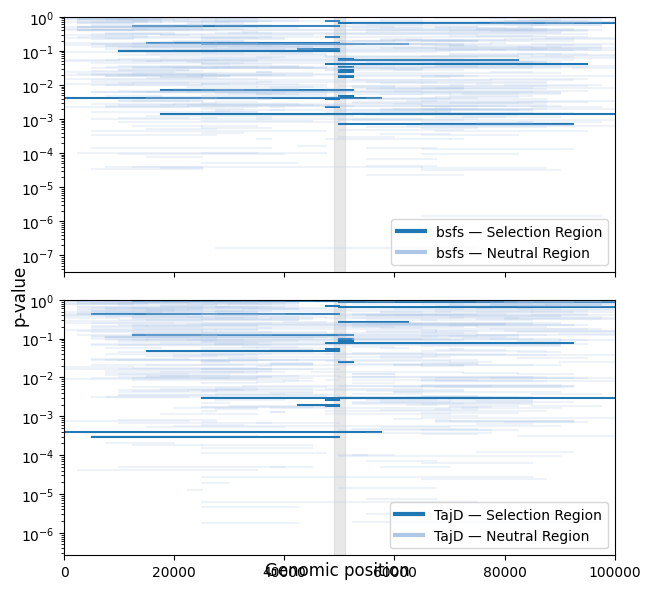

In [32]:
# # --- Band around the selected site (use a size that fits in L) ---
# L = X.Args[selected_key]['L']
# mut = L // 2

# # choose a narrow band around the selected site, e.g. 5% of L total width
# band_half = max(int(0.025 * L), 1_000)   # ~2.5% each side, at least 1 kb
# st = max(0, mut - band_half)
# en = min(L, mut + band_half)

# --- Plot like their genome-scan figure ---
fig, ax = plt.subplots(len(stats), 1, figsize=(6.5, 3*len(stats)), sharex=True)
if len(stats) == 1:
    ax = [ax]

for i, key in enumerate(stats):
    # grey band only over [st, en]
    ax[i].fill_between([st, en], [1e-50, 1e-50], [1, 1], color='lightgray', alpha=0.5)

    ds = dscans[key].copy()
    # (defensive) ensure numeric and within [0, L]
    ds['start'] = ds['start'].clip(lower=0, upper=L)
    ds['end']   = ds['end'].clip(lower=0, upper=L)

    # draw each segment as a horizontal bar
    for j, row in ds.iterrows():
        y = row['p' + key]
        if not np.isfinite(y) or y <= 0:
            continue
        ax[i].plot([row['start'], row['end']], [y, y],
                   color=row.get('color', '#1f77b4'),
                   alpha=row.get('alpha', 0.6),
                   linewidth=1.5)

    # legend stubs
    sel_col, neu_col = ('#1f77b4', '#aec7e8') if key not in ('TajD','bsfs') else ('#1f77b4', '#aec7e8')
    ax[i].plot([], [], color=sel_col, label=f'{key} — Selection Region', linewidth=3)
    ax[i].plot([], [], color=neu_col, label=f'{key} — Neutral Region',   linewidth=3)

    # axes
    ax[i].set_xlim(0, L)             # <— force genomic scale to [0, L]
    ax[i].set_yscale('log')
    # pick a safe y-min
    vals = ds['p' + key].replace([np.inf, -np.inf], np.nan).dropna()
    ax[i].set_ylim(max(vals.min()/5, 1e-8) if len(vals) else 1e-8, 1)
    ax[i].legend(loc='lower right', prop={'size': 10})

fig.text(0.51, 0.04, 'Genomic position', ha='center', va='center', size=12)
fig.text(0.02, 0.5, 'p-value', rotation=90, ha='center', va='center', size=12)
plt.tight_layout()
plt.show()

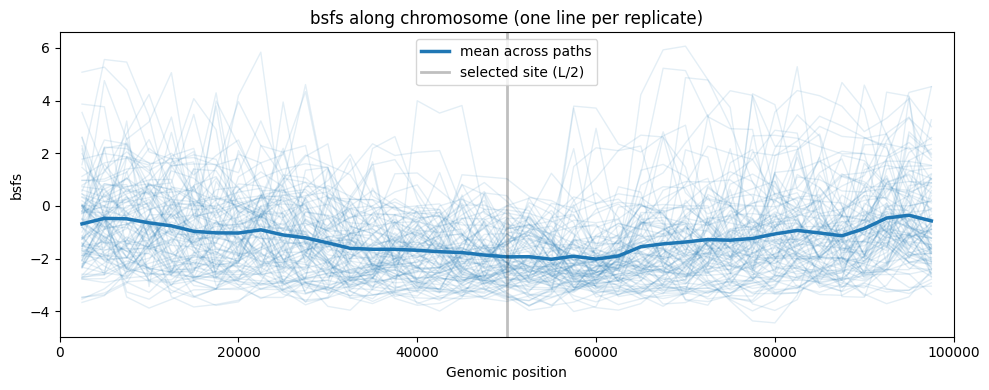

In [28]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---- point to your merged file ----
fname = "outs/3s=0.01F=0.75.csv"
if not os.path.exists(fname):
    fname = "3s=0.01F=0.75.csv"  # fall back if you already moved it

df = pd.read_csv(fname)

# keep only what we need and clean up
cols_needed = {'start','end','path','bsfs'}
missing = cols_needed - set(df.columns)
if missing:
    raise ValueError(f"CSV is missing columns: {missing}")

df = df[list(cols_needed)].replace([np.inf, -np.inf], np.nan).dropna()

# x-position per window (midpoint) and sort within each replicate
df['pos'] = (df['start'] + df['end']) / 2
df = df.sort_values(['path','pos'])

# infer chromosome length from the windows (for nice x-limits / vertical marker)
L = float(df[['start','end']].to_numpy().max())
sel_site = L / 2.0  # your SLiM put the beneficial mutation at L/2

# ---- plot each replicate as a faint line ----
plt.figure(figsize=(10,4))

for pid, sub in df.groupby('path', sort=False):
    plt.plot(sub['pos'].to_numpy(), sub['bsfs'].to_numpy(),
             alpha=0.12, linewidth=1, color='tab:blue')

# optional: bold average across replicates at each window midpoint (if grids align)
# If grids don’t align perfectly, this still works OK when many windows exist.
avg = (df.groupby('pos', as_index=False)['bsfs'].mean()
         .sort_values('pos'))
plt.plot(avg['pos'], avg['bsfs'], linewidth=2.5, label='mean across paths', color='tab:blue')

# mark the selected site (middle) and tidy up
plt.axvline(sel_site, color='k', alpha=0.25, linewidth=2, label='selected site (L/2)')
plt.xlim(0, L)
plt.xlabel('Genomic position')
plt.ylabel('bsfs')
plt.title('bsfs along chromosome (one line per replicate)')
plt.legend()
plt.tight_layout()
plt.show()

In [29]:
df.sort_values(by=["path", "start"])

,end,bsfs,start,path,pos
0,5000,-1.801974,0,3060000,2500.0
30,7500,-1.914498,2500,3060000,5000.0
22,10000,-1.516613,5000,3060000,7500.0
23,12500,-2.829605,7500,3060000,10000.0
24,15000,-2.808285,10000,3060000,12500.0
...,...,...,...,...,...
3874,90000,3.783173,85000,3060099,87500.0
3875,92500,2.821689,87500,3060099,90000.0
3868,95000,3.328075,90000,3060099,92500.0
3881,97500,4.064907,92500,3060099,95000.0


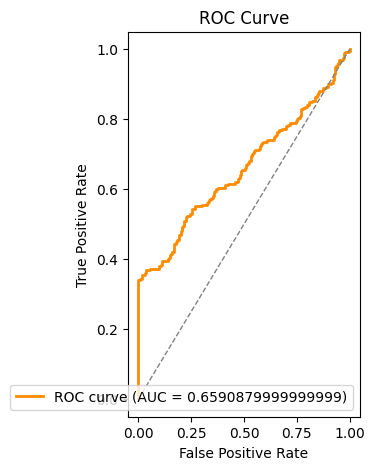

In [25]:
from sklearn.metrics import roc_curve, auc as sklearn_auc
import random
zeros = [0] * 250
ones = [1] * 250
y = zeros + ones
zero_x  = [random.random() for _ in range(250)]
one_x = [random.uniform(0, 1.4) for _ in range(250)]
x = zero_x + one_x

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y, x)
roc_auc = sklearn_auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(3, 5))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc})")
plt.plot([0, 1], [0, 1], color="gray", lw=1, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()